Домашнее_задание_от_Нетологии_по_теме "Классификация: Логистическая регрессия и SVM"
Автор - Корнилов А.В.
Преподователь - Пономарева Юлия

In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Перед обучением моделей произведем анализ исходных данных

In [391]:
data = pd.read_csv('https://raw.githubusercontent.com/koresh123/-Classification-Logistic-Regression-and-SVM/refs/heads/main/adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [392]:
data.shape

(48842, 15)

In [393]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [441]:
income_counts = data['income'].value_counts()

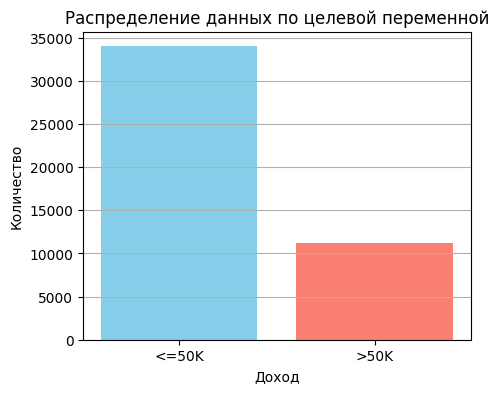

In [449]:
plt.figure(figsize=(5, 4))
plt.bar(income_counts.index, income_counts.values, color=['skyblue', 'salmon'])
plt.title('Распределение данных по целевой переменной')
plt.xlabel('Доход')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y')

Первоначальный анализ говорит нам, что в данных нет пропусков и пустых строк, а также, что:
    - классы не сбалансированные. Соотношение примерно 3 к 1

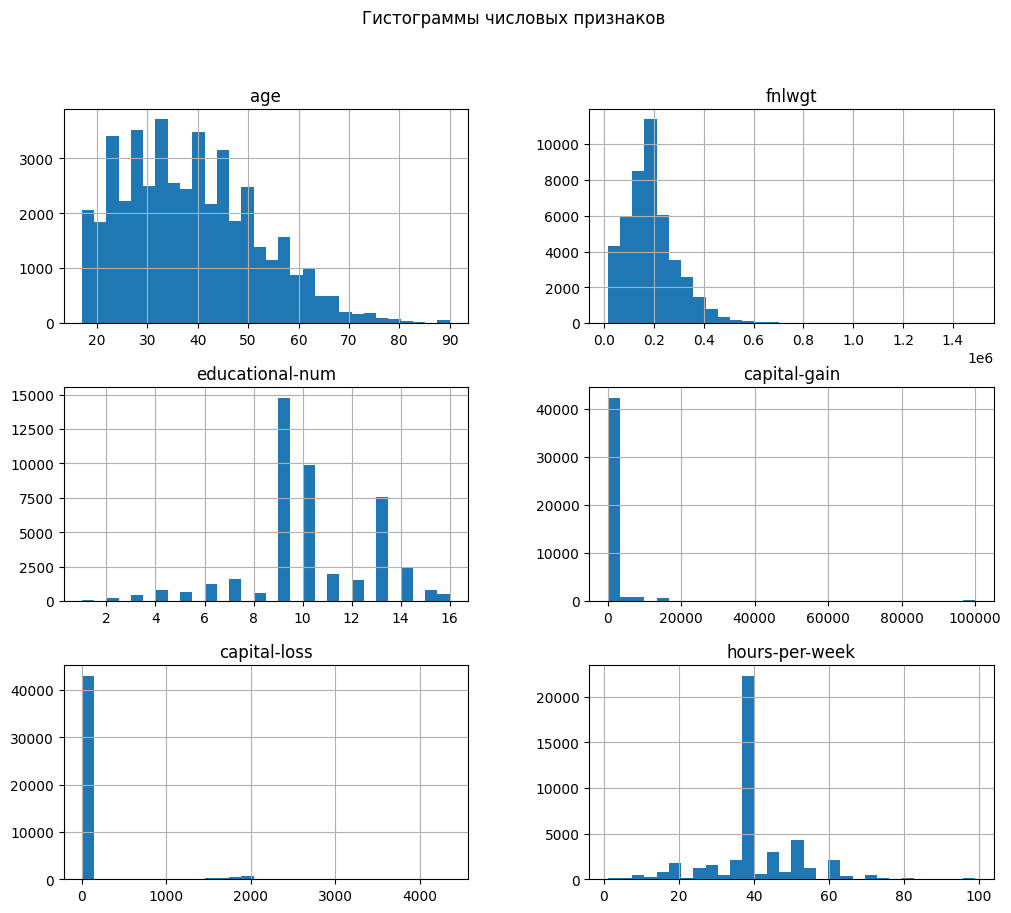

In [450]:
data.hist(figsize=(12, 10), bins=30)
plt.suptitle('Гистограммы числовых признаков')
plt.show()

Из гистограмм видно, что числовые признаки имеют также не сбалансированность. Значительные коллебания по max значениям. Возможно, без стандартизации итоговые результаты будет не оптимальными

После визуального(глазами)  анализа данных делаем вывод, что в данном дата_сете пропуски заменены знаками вопроса(?)
при анализе того или иного столбца как целевого признака будем это учитывать

In [394]:
data.apply(lambda x: (x == '?')).sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Первоначально необходимо определиться со стротегией обучения, а именно
какие столбцы мы будем использователь как признаки для обучения модели
идея - разбить их на группы, то есть 
1. Целевая переменная очевидно зависит(age, workclass, gender, hours-per-week, native-country)
2. Целевая переменная может зависить(education, educational-num, marital-status, occupation)

в случае, если мы решим использовать как признак один из столбцов workclass, occupation или native-country сделаем drop(удалим) строки котоыре имею в столбцах значения вопроса

In [395]:
data_obvious_connection = data[['age', 'workclass', 'gender', 'hours-per-week', 'native-country', 'income']]
data_obvious_connection = data_obvious_connection[
    (data_obvious_connection['native-country'] != '?') & (data_obvious_connection['workclass'] != '?')]
data_obvious_connection.apply(lambda x: (x == '?')).sum()

age               0
workclass         0
gender            0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [396]:
data_obvious_connection

,age,workclass,gender,hours-per-week,native-country,income
0,25,Private,Male,40,United-States,<=50K
1,38,Private,Male,50,United-States,<=50K
2,28,Local-gov,Male,40,United-States,>50K
3,44,Private,Male,40,United-States,>50K
5,34,Private,Male,30,United-States,<=50K
...,...,...,...,...,...,...
48837,27,Private,Female,38,United-States,<=50K
48838,40,Private,Male,40,United-States,>50K
48839,58,Private,Female,40,United-States,<=50K
48840,22,Private,Male,20,United-States,<=50K


In [397]:
X = pd.get_dummies(data_obvious_connection, columns=['workclass', 'gender', 'native-country'])
Y = X['income']
del X['income']


Делим наши данные на обучающиеся и тестовые в соотношение 80/20

In [398]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [399]:
model_obvious_connection = LogisticRegression()
model_obvious_connection.fit(X_train, Y_train) 

e:\Python\netologiya\-Classification-Logistic-Regression-and-SVM\venv_logistic_and_SVM_regracion\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [400]:
predict__obvious_connection = model_obvious_connection.predict_proba(X_test)

In [401]:
predict__obvious_connection

array([[0.73526974, 0.26473026],
       [0.97061897, 0.02938103],
       [0.73334531, 0.26665469],
       ...,
       [0.78557548, 0.21442452],
       [0.47846762, 0.52153238],
       [0.93712086, 0.06287914]])

In [402]:
model_obvious_connection.score(X_test, Y_test)

0.7590361445783133

In [403]:
model_obvious_connection.score(X_train, Y_train)

0.759154345723366

In [404]:
coef = model_obvious_connection.coef_
intercept = model_obvious_connection.intercept_

In [405]:
print(coef, intercept)

[[ 0.04186011  0.03984964 -0.00604095 -0.40415185 -0.07947037 -0.68511979
   0.09673798 -0.99889032 -0.36651536 -0.30526517 -1.90830506 -0.8404108
   0.14553949  0.32931501  0.26077102 -0.54264523 -0.09826693 -0.58739655
  -0.09125569 -0.60407659  0.61936839  0.33364324  0.53950591 -0.04212407
  -0.45977385 -0.21907116 -0.00467188 -0.07852653  0.10022426  0.03945051
   0.66207917  0.25238172 -0.02779927  0.22859768 -0.17538243  0.26567311
  -0.15744604 -1.89091336 -0.21021589 -0.15593742 -0.14779884  0.60209767
  -0.05839037 -0.26022732 -0.58304317 -0.22207492 -0.41654077  0.4109125
  -0.13223082 -0.17124581  0.15269796 -0.38809898  0.03418038]] [-2.89130694]


In [406]:
np.sum(X.iloc[0].values * model_obvious_connection.coef_) + model_obvious_connection.intercept_


array([-1.62365118])

1. На данной выборке точность нашей модели 0.759
2. Не понятно, какие графики(график) можно и нужно построить
3. np.sum(X.iloc[0].values * model_obvious_connection.coef_) + model_obvious_connection.intercept_  нужно ли как то использовать данную формулу?

Переходим к следующему анализу, будем для признаков использовать дополнительно education, educational-num, marital-status, occupation

In [407]:
data_obvious_connection = data[['age', 'workclass', 'gender', 'hours-per-week', 'native-country', 'income', 'education', 'educational-num', 'marital-status', 'occupation']]
data_obvious_connection = data_obvious_connection[
    (data_obvious_connection['native-country'] != '?') & (data_obvious_connection['workclass'] != '?') & (data_obvious_connection['occupation'] != '?')]
data_obvious_connection.apply(lambda x: (x == '?')).sum()

age                0
workclass          0
gender             0
hours-per-week     0
native-country     0
income             0
education          0
educational-num    0
marital-status     0
occupation         0
dtype: int64

In [408]:
data_obvious_connection

,age,workclass,gender,hours-per-week,native-country,income,education,educational-num,marital-status,occupation
0,25,Private,Male,40,United-States,<=50K,11th,7,Never-married,Machine-op-inspct
1,38,Private,Male,50,United-States,<=50K,HS-grad,9,Married-civ-spouse,Farming-fishing
2,28,Local-gov,Male,40,United-States,>50K,Assoc-acdm,12,Married-civ-spouse,Protective-serv
3,44,Private,Male,40,United-States,>50K,Some-college,10,Married-civ-spouse,Machine-op-inspct
5,34,Private,Male,30,United-States,<=50K,10th,6,Never-married,Other-service
...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Female,38,United-States,<=50K,Assoc-acdm,12,Married-civ-spouse,Tech-support
48838,40,Private,Male,40,United-States,>50K,HS-grad,9,Married-civ-spouse,Machine-op-inspct
48839,58,Private,Female,40,United-States,<=50K,HS-grad,9,Widowed,Adm-clerical
48840,22,Private,Male,20,United-States,<=50K,HS-grad,9,Never-married,Adm-clerical


In [409]:
X = pd.get_dummies(data_obvious_connection, columns=['workclass', 'gender', 'native-country', 'education','marital-status', 'occupation'])
Y = X['income']
del X['income']

In [410]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [411]:
model_additional_signs = LogisticRegression()
model_additional_signs.fit(X_train, Y_train)

e:\Python\netologiya\-Classification-Logistic-Regression-and-SVM\venv_logistic_and_SVM_regracion\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [412]:
model_additional_signs.score(X_test, Y_test)

0.8309563294637922

In [413]:
model_additional_signs.score(X_train, Y_train)

0.8297813527932112

Точность предсказаний выросла. На тестовой составляет 0.83 на обучающей 0.829

Проведем последний эксперимент. Проверим точность модели на всех возможных признаках

In [414]:
data = data[
    (data['native-country'] != '?') & (data['workclass'] != '?') & (data['occupation'] != '?')]
data.apply(lambda x: (x == '?')).sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

В данном случае, из-за разброса значений в разных признаках сделаем стандартизацию данных

In [415]:
X = pd.get_dummies(data, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'])
Y = X['income']
del X['income']

In [416]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [417]:
model_all_signs_with_standart = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

In [418]:
model_all_signs_with_standart.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [419]:
model_all_signs_with_standart.score(X_test, Y_test)

0.8511885019347706

In [420]:
model_all_signs_with_standart.score(X_train, Y_train)

0.8486054675622633

In [421]:
model_all_signs_not_standart = LogisticRegression()
model_all_signs_not_standart.fit(X_train, Y_train)

e:\Python\netologiya\-Classification-Logistic-Regression-and-SVM\venv_logistic_and_SVM_regracion\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [422]:
model_all_signs_not_standart.score(X_test, Y_test)

0.7953565505804312

In [423]:
model_all_signs_not_standart.score(X_train, Y_train)

0.7900046991182242

Лучший результат - все данные со стандартизацией, точность 0.8511

-------------------------------------------------------------------------------

Решаем задачу с помощью метода SVM

In [424]:
model_svc_all_signs = make_pipeline(
    StandardScaler(),
    SVC()
)

In [425]:
model_svc_all_signs.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [426]:
model_svc_all_signs.score(X_test, Y_test)

0.8512990602542841

In [427]:
model_svc_all_signs.score(X_train, Y_train)

0.8586118251928021

Выводы по работе:
1. При работе с данными были удалены строки у которых в значениях были знаки вопроса(?). Для текстовых данных применен метод one hot encoding
2. Обе модели дают примерно одинаковый результат, точность логис.рег(test-0.8511, train-0.8486)
    SVC(test-0.0.8512, train-0.0.8586)
3. Обе модели справились с задачей, результат точности 85% хороший. 
    Улучшить модель, возможно, сбалансировав классы увеличив массива данных, а также введение нового признака